# 📚 Bangla News Categorization using BERT

This project focuses on classifying Bangla news articles into predefined categories using a fine-tuned BERT-based language model (`sagorsarker/bangla-bert-base`), Bangla-Electra.

The reason for choosing these model is that they performed state of the art in text/nlp classification task
which you can check on the huggingface sagorsarker/bangla-bert-base: https://huggingface.co/sagorsarker/bangla-bert-base here you will find that Bangla Bert Base has outperformed the other model and Bangla Benchmarks in  https://colab.research.google.com/drive/1vltPI81atzRvlALv4eCvEB0KdFoEaCOb#scrollTo=pqsH5gU-QxVf
we will also try csebuetnlp/banglabert_small because of its very low number of parameters(13M) just to check how it performs in comparison the other three.


The workflow includes preprocessing raw Bangla text, removing irrelevant tokens, training a transformer model with early stopping, and visualizing word distributions across categories.

The aim is to develop an accurate and robust model that understands Bangla language nuances and effectively categorizes news content for downstream NLP applications.


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")




import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim import AdamW
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler
from tqdm import tqdm

# **Data Load and Exploratory Data Analysis:EDA**

In [ ]:
bn = pd.read_csv('Bangla_news.csv',
                 encoding='utf-8',
                 sep=',',
                 engine='python')


In [ ]:
bn.shape

(11904, 6)

In [ ]:
bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   title           11904 non-null  object
 1   published_date  11904 non-null  object
 2   reporter        10914 non-null  object
 3   category        11904 non-null  object
 4   url             11904 non-null  object
 5   content         11904 non-null  object
dtypes: object(6)
memory usage: 558.1+ KB


In [ ]:
bn.isnull().sum()

,0
title,0
published_date,0
reporter,990
category,0
url,0
content,0


There are 990 null values in the reporter column. However this doesn't matter to us. because we will not work with this column. we will work only with title,content and category.

In [ ]:
bn.duplicated().sum()

np.int64(0)

We will remove the unncessary columns

In [ ]:
bn.drop(columns=['title','published_date','reporter','url'],inplace=True)

In [ ]:
bn['category'].value_counts()

,count
category,
sports,2976
international,2976
entertainment,2976
national,2976


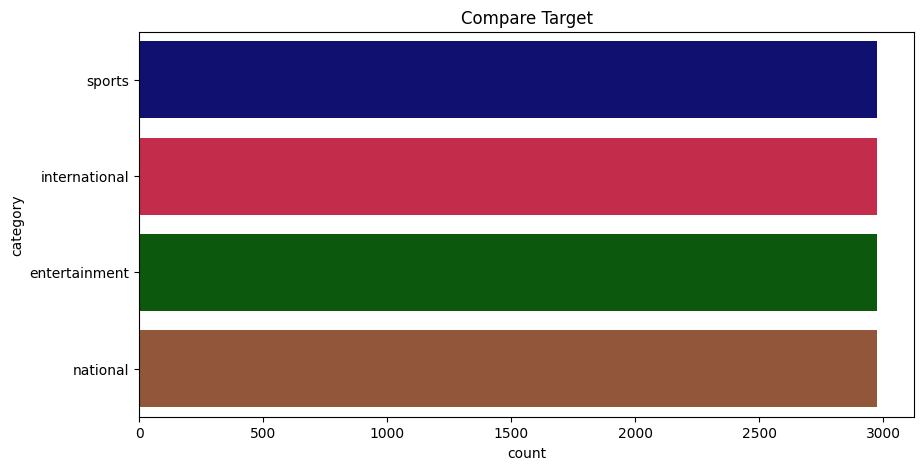

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(data=bn, y="category",palette=["navy","crimson","darkgreen","sienna"])
plt.title("Compare Target")
plt.show()

Nice! This is a balanced dataset with four classes.

Now let's see string leghth of conent for each category

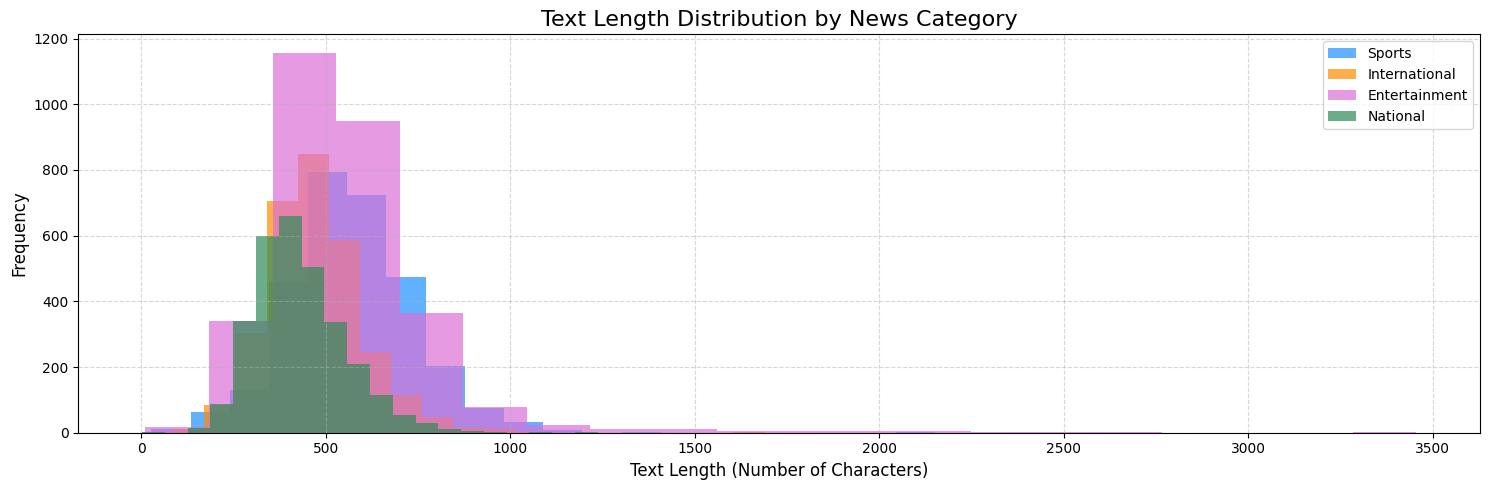

In [ ]:

sports = bn[bn["category"] == "sports"]["content"].str.len()
international = bn[bn["category"] == "international"]["content"].str.len()
entertainment = bn[bn["category"] == "entertainment"]["content"].str.len()
national = bn[bn["category"] == "national"]["content"].str.len()

plt.figure(figsize=(15, 5))

plt.hist(sports, bins=20, label='Sports', color="dodgerblue", alpha=0.7)
plt.hist(international, bins=20, label='International', color="darkorange", alpha=0.7)
plt.hist(entertainment, bins=20, label='Entertainment', color="orchid", alpha=0.7)
plt.hist(national, bins=20, label='National', color="seagreen", alpha=0.7)

plt.title("Text Length Distribution by News Category", fontsize=16)
plt.xlabel("Text Length (Number of Characters)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


In [ ]:
bn.head()

,category,content
0,sports,ছবি: সংগৃহীত সিন নদীতে অলিম্পিকের উদ্বোধনী অনু...
1,sports,২০২৫ সালের জানুয়ারিতে এশিয়ান ক্রিকেট কাউন্স...
2,sports,ফিফা বিশ্বকাপ ২০৩০ ও ৩৪ সালের স্বাগতিক হবার ল...
3,sports,প্যারিস অলিম্পিকে কোয়ার্টার ফাইনাল রেসে টিকে ...
4,sports,আজ ভারত–শ্রীলঙ্কার তৃতীয় টি–টোয়েন্টি অলিম্পিকে...


"ছবি: সংগৃহীত" at the start of some content which has no meaning to the actual content of the news. Let's see if there are many rows that has similar words. Let's check some tail rows.

In [ ]:
bn.tail()

,category,content
11899,national,রাজধানীর বাড্ডার ইউনাইটেড মেডিকেল কলেজ হাসপাত...
11900,national,আখেরি মোনাজাতের মাধ্যমে শেষ হয়েছে গাজীপুরে টঙ...
11901,national,ফাইল ছবি ভারতের আদালতে বিচারকাজ শেষ না হওয়ায়...
11902,national,ফাইল ছবি। সাংবাদিক দম্পতি সাগর সরওয়ার ও মেহেরু...
11903,national,আজ আখেরি মোনাজাতের মাধ্যমে শেষ হচ্ছে ইজতেমার ...


"ফাইল ছবি" at the start of some content is also irrelevant to content. Let's check some middle rows.

Let's check some rows from the middle

In [ ]:
num_rows = len(bn)
mid_row = int(num_rows/2)
middle_rows = bn.iloc[mid_row : mid_row + 5]
middle_rows

,category,content
5952,entertainment,সরকারি চাকরিতে কোটা সংস্কারের দাবিতে ছাত্র-ছা...
5953,entertainment,গত কয়েকদিন ধরেই সরকারি চাকরিতে কোটা সংস্কার ...
5954,entertainment,কোপা আমেরিকার ফাইনালে কলম্বিয়াকে হারিয়ে রেক...
5955,entertainment,ভারতের শীর্ষ ধনকুবের মুকেশ আম্বানির ছেলে অনন্...
5956,entertainment,মাসব্যাপী অনুষ্ঠানের পর অবশেষে ভারতের সবচেয়ে...


No, irrelevant texts found in the middle rows.

# Data Cleaning

if you look into the data you will see that there are functuations stopwords in the data. we will remove them from content as well as do other some preprocessing.

In [ ]:
bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  11904 non-null  object
 1   content   11904 non-null  object
dtypes: object(2)
memory usage: 186.1+ KB


We will combine bangla stopwords from two different datasets then we will remove them from the content as they are not gonna impact so much on the model. Remember there are a lot of words in some categories like more than 1000 so, removing the stopwords will reduce the size and the important words will be in the text. As a result when we set token length to 512 the probalbility of loosing important data will be reduced.

In [ ]:
sw = pd.read_excel("bangla_stopwords.xlsx")
sw.head()

,Unnamed: 0,word_list
0,0,অই
1,1,অগত্যা
2,2,অত: পর
3,3,অতএব
4,4,অথচ


In [ ]:
more_sw = pd.read_csv("bangla_sw.csv")
more_sw.head()

,word_list
0,অতএব
1,অথচ
2,অথবা
3,অনুযায়ী
4,অনেক


In [ ]:
sw_list = sw['word_list'].tolist() + more_sw['word_list'].tolist()

In [ ]:
len(sw_list)

1130

Remove the stopwords that are common to both datasets

In [ ]:
sw_list = list(set(sw_list))
len(sw_list)

752

Now, let's clean stopwords and other unnecessary things from the dataset

In [ ]:
import re

def clean_text(text):
    row = str(text)
    row = row.replace('\n', ' ') # replace new line with space
    row = row.replace('\t', ' ') # replace tab with space
    row = row.replace('\\', "")  # replace // with space
    row = re.sub(r"^(ছবি[:：]?\s*সংগৃহীত|ফাইল\sছবি)\s*", "", row) # irrelevant data removal from content
    row = re.sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', '', row) # unnecessary punctuation removal
    row = re.sub(r' +', ' ', row)
    row = row.replace("।", "")
    row = re.sub(r'[১২৩৪৫৬৭৮৯০]', '', row)
    row = re.sub(r'[1234567890]', '', row)
    row = row.replace('’', '')
    row = row.replace('‘', '')

    row = row.split()
    row = [w for w in row if w not in sw_list]
    row = " ".join(row)

    return row


# Feature Engineering

Already removed the unnecessary columns rom the dataset. Now, we will create a new text column which will be cleaned and then we will drop the actual content when we are done with it.

In [ ]:
bn['text'] = bn['content'].apply(clean_text)


In [ ]:
bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  11904 non-null  object
 1   content   11904 non-null  object
 2   text      11904 non-null  object
dtypes: object(3)
memory usage: 279.1+ KB


In [ ]:
bn.drop(columns=['content'],inplace=True)

In [ ]:
bn.head()

,category,text
0,sports,সিন নদীতে অলিম্পিকের উদ্বোধনী অনুষ্ঠান নদীর পা...
1,sports,সালের জানুয়ারিতে এশিয়ান ক্রিকেট কাউন্সিল (এস...
2,sports,ফিফা বিশ্বকাপ সালের স্বাগতিক হবার লড়াইয়ের বিডি...
3,sports,প্যারিস অলিম্পিকে কোয়ার্টার ফাইনাল রেসে টিকে থ...
4,sports,ভারত–শ্রীলঙ্কার তৃতীয় টি–টোয়েন্টি অলিম্পিকে সো...


সালের,সাল,মি.,টা,মিনিটে,মিনিট still these words are unnecessary in the content. these need to be removed.

## custom stopwords removal

In [ ]:
custom_sw = ["সালের","সাল","মি.","টা","মিনিটে","মিনিট"]

In [ ]:
sw_list = sw_list + custom_sw

In [ ]:
len(sw_list)

758

In [ ]:
bn['text'] = bn['text'].apply(clean_text)


In [ ]:
bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  11904 non-null  object
 1   text      11904 non-null  object
dtypes: object(2)
memory usage: 186.1+ KB


# Saving the final cleaned dataset

In [ ]:
bn.to_csv("final_data.csv", index=False)

#Load the cleaned dataset

In [2]:
bn = pd.read_csv("final_data.csv")
bn.head()

,category,text
0,sports,সিন নদীতে অলিম্পিকের উদ্বোধনী অনুষ্ঠান নদীর পা...
1,sports,জানুয়ারিতে এশিয়ান ক্রিকেট কাউন্সিল (এসিসির) ...
2,sports,ফিফা বিশ্বকাপ স্বাগতিক হবার লড়াইয়ের বিডিং ডেটল...
3,sports,প্যারিস অলিম্পিকে কোয়ার্টার ফাইনাল রেসে টিকে থ...
4,sports,ভারত–শ্রীলঙ্কার তৃতীয় টি–টোয়েন্টি অলিম্পিকে সো...


In [3]:
bn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11904 entries, 0 to 11903
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  11904 non-null  object
 1   text      11902 non-null  object
dtypes: object(2)
memory usage: 186.1+ KB


In [4]:
bn.isnull().sum()

,0
category,0
text,2


In [5]:
bn.dropna(subset=['text'],inplace=True)


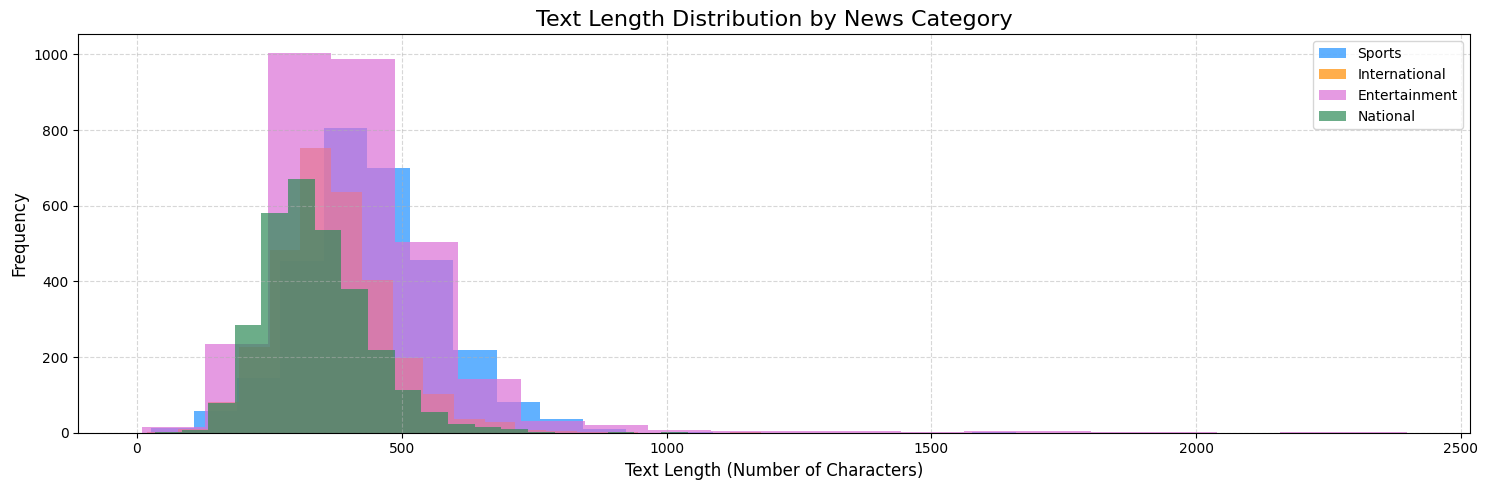

In [6]:
sports = bn[bn["category"] == "sports"]["text"].str.len()
international = bn[bn["category"] == "international"]["text"].str.len()
entertainment = bn[bn["category"] == "entertainment"]["text"].str.len()
national = bn[bn["category"] == "national"]["text"].str.len()

plt.figure(figsize=(15, 5))

plt.hist(sports, bins=20, label='Sports', color="dodgerblue", alpha=0.7)
plt.hist(international, bins=20, label='International', color="darkorange", alpha=0.7)
plt.hist(entertainment, bins=20, label='Entertainment', color="orchid", alpha=0.7)
plt.hist(national, bins=20, label='National', color="seagreen", alpha=0.7)

plt.title("Text Length Distribution by News Category", fontsize=16)
plt.xlabel("Text Length (Number of Characters)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


See! when we have done stopwords removal and cleaning some long texts row has been removed.

In [7]:
label2id = {'sports': 0, 'international': 1, 'entertainment': 2, 'national': 3}
bn['label'] = bn['category'].apply(lambda x: label2id[x])
bn.head()

,category,text,label
0,sports,সিন নদীতে অলিম্পিকের উদ্বোধনী অনুষ্ঠান নদীর পা...,0
1,sports,জানুয়ারিতে এশিয়ান ক্রিকেট কাউন্সিল (এসিসির) ...,0
2,sports,ফিফা বিশ্বকাপ স্বাগতিক হবার লড়াইয়ের বিডিং ডেটল...,0
3,sports,প্যারিস অলিম্পিকে কোয়ার্টার ফাইনাল রেসে টিকে থ...,0
4,sports,ভারত–শ্রীলঙ্কার তৃতীয় টি–টোয়েন্টি অলিম্পিকে সো...,0


In [8]:
!pip install -q dataloader datasets

  Preparing metadata (setup.py) ... done


# Bangla-BERT-base

## 🧠 Model Setup and Dataset Preparation

This section prepares the data and model to fine-tune `sagorsarker/bangla-bert-base` for Bangla news categorization.


In [10]:
# loading the tokenizer and the model sagorsarker/bangla-bert-base from Hugging Face with a classification head for 4 categories.
model_name = "sagorsarker/bangla-bert-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# creating a custom PyTorch Dataset class to handle text tokenization and label formatting. Each sample includes input IDs, attention masks, and labels.
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# We split the dataset bn into 80% training, 10% validation, and 10% testing. Stratified sampling ensures balanced category distribution in each split.We split the dataset bn into 80% training, 10% validation, and 10% testing. Stratified sampling ensures balanced category distribution in each split.
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    bn['text'], bn['label'], test_size=0.2, random_state=42, stratify=bn['label']
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# We wrap the data using our NewsDataset class and prepare DataLoaders for batch processing. Batch size is set to 8.

batch_size = 8
train_dataset = NewsDataset(train_texts, train_labels.values)
val_dataset = NewsDataset(val_texts, val_labels.values)
test_dataset = NewsDataset(test_texts, test_labels.values)

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size)
test_loader = DataLoader(test_dataset, batch_size= batch_size)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

# 🔁 Model Training with Early Stopping

This section covers the fine-tuning of Bangla BERT on the training data with **early stopping** to prevent overfitting. A **linear learning rate scheduler** is also used for optimized learning.


In [ ]:
# Early stopping config with threshold
best_val_loss = float("inf") # Stores the lowest validation loss seen so far.
patience = 2 # Number of validation rounds to wait for improvement before stopping.
patience_counter = 0
num_epochs = 10
threshold = 0.01 #Minimum improvement in validation loss considered significant.

num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


## 🔁 Step 8: Training Loop with Validation and Early Stopping

The model is trained for up to `num_epochs`, but it can stop earlier if the validation loss does not improve significantly for a number of `patience` consecutive epochs. This helps prevent overfitting and saves training time.



In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Early stopping with threshold
    improvement = best_val_loss - avg_val_loss
    if improvement > threshold:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "banglabert_category_model.pt")
    else:
        patience_counter += 1
        print(f"No significant improvement (Δ={improvement:.4f}), patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save tokenizer separately
tokenizer.save_pretrained("banglabert_tokenizer")



### 🔹 Training Phase

- The model is set to **train mode**.
- Each batch of data is **forwarded** through the model.
- **Loss is computed**, then **backpropagated** to update the model's parameters.
- The **learning rate** is updated using the defined **scheduler**.



### 🔹 Validation Phase

- The model is set to **evaluation mode** (no gradient updates).
- **Validation loss** is calculated using the validation dataset.
- No weights are updated during this phase.



### 🔹 Early Stopping Check

- If the **validation loss improves** by more than the `threshold`, the model's state is saved and the `patience_counter` is **reset**.
- If there is **no significant improvement**, the `patience_counter` is **incremented**.
- If the `patience_counter` **exceeds** the allowed `patience`, training is **stopped early**.



This strategy ensures efficient training and prevents the model from overfitting to the training data.


# Load Trained Model for Evaluation and Inference

In this step, we load the trained Bangla BERT model and tokenizer to evaluate it on the test data. This setup is crucial for making predictions and analyzing the model's performance using various metrics.


### Configuration

- **Model Name:** We use `"sagorsarker/bangla-bert-base"`, a pretrained Bangla BERT model.
- **Number of Labels:** Set to `4` corresponding to the categories: `sports`, `international`, `entertainment`, `national`.
- **Device Setup:** Uses `GPU` if available, otherwise defaults to `CPU`.


### Label Mapping

- `label2id`: A dictionary mapping category names to numerical IDs.
- `id2label`: The inverse mapping to convert prediction IDs back to readable category names.

This mapping is necessary for both training and interpreting model predictions.


### Load Tokenizer and Model

- **Tokenizer**: Loaded from the saved `banglabert_tokenizer` directory.
- **Model**: Initialized using the pretrained base and modified for sequence classification with 4 output labels.
- **Weights**: Loaded from the saved model checkpoint (`banglabert_category_model.pt`).

```python
model.load_state_dict(torch.load("banglabert_category_model.pt", map_location=device))


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Config
model_name = "sagorsarker/bangla-bert-base"
num_labels = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label mapping
label2id = {'sports': 0, 'international': 1, 'entertainment': 2, 'national': 3}
id2label = {v: k for k, v in label2id.items()}

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("banglabert_tokenizer")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.load_state_dict(torch.load("banglabert_category_model.pt", map_location=device))
model.to(device)
model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(102025, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1

# Model Evaluation on Test Set

After training and saving the best model, we now evaluate its performance on the **test dataset**. This step helps assess how well the model generalizes to unseen data.


### Inference and Predictions

- We loop through the test data in batches and pass them through the model in **evaluation mode**.
- **Predictions** are obtained by selecting the class with the highest logit value using `argmax`.
- Predictions and true labels are collected for metric calculation.

```python
with torch.no_grad():
    for batch in test_loader:
        ...
        preds = torch.argmax(outputs.logits, dim=1)
        ...


✅ Accuracy: 0.9647

Classification Report:
               precision    recall  f1-score   support

       sports       0.98      0.99      0.99       297
international       0.96      0.95      0.95       298
entertainment       0.95      0.97      0.96       298
     national       0.97      0.95      0.96       298

     accuracy                           0.96      1191
    macro avg       0.96      0.96      0.96      1191
 weighted avg       0.96      0.96      0.96      1191



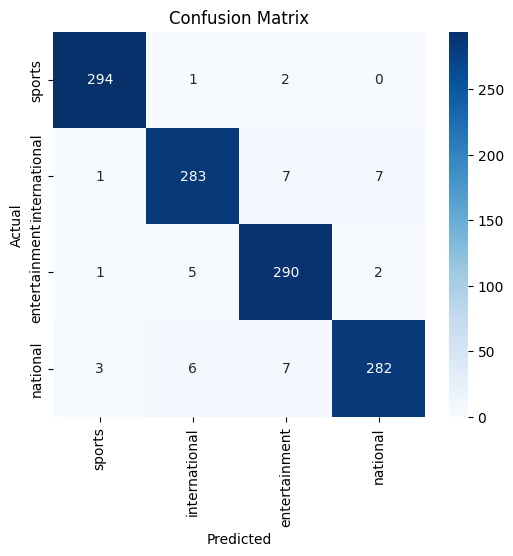

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[id2label[i] for i in range(4)]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=id2label.values(), yticklabels=id2label.values(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


## Evaluation Summary

The BanglaBERT-based text classification model achieved an impressive **accuracy of 96.47%** on the test dataset.

### Key Takeaways from the Classification Report:
- All four categories (`sports`, `international`, `entertainment`, `national`) have **high precision, recall, and F1-scores**, indicating that the model performs well across all classes.
- **Macro and Weighted Averages** are both above **0.96**, confirming balanced performance regardless of class size.
- The model shows the highest performance on the `sports` category (F1-score: 0.99), and consistently strong results on the other categories as well.

This suggests that the model generalizes well and is highly effective for multilingual news classification in Bangla.

### Confusion Matrix Analysis

The confusion matrix provides a detailed breakdown of the model’s classification performance across the four news categories:

- **Diagonal cells** represent correct predictions.
- **Off-diagonal cells** indicate misclassifications.

#### Observations:
- **Sports**: Predicted almost perfectly with only 3 misclassifications (1 as international, 2 as entertainment).
- **International**: 283 out of 298 correctly predicted. Most confusion was with `entertainment` (7) and `national` (7).
- **Entertainment**: 290 correct predictions. A few were misclassified as `international` (5), `national` (2), or `sports` (1).
- **National**: 282 correct. Slight confusion with all other classes, especially `entertainment` (7).

Overall, the model performs exceptionally well with minimal confusion, confirming its ability to distinguish between Bangla news categories with high precision.


### Prediction bangla-bert-base

In [ ]:
def predict_category(text):
    model.eval()
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        outputs = model(**inputs)
        pred = torch.argmax(outputs.logits, dim=1).item()

    return id2label[pred]

# 🔎 Example
# text = "বাংলাদেশ ক্রিকেট দল দুর্দান্ত খেলছে।"
# text = "শাকিব খানের নতুন সিনেমা ঈদে মুক্তি পাচ্ছে।"
# text = "প্রধানমন্ত্রী বলেছেন, আগামী বছর দেশের সব গ্রামে বিদ্যুৎ পৌঁছাবে।"
text = "যুক্তরাষ্ট্রে প্রেসিডেন্ট নির্বাচনে আবারো বাইডেন ও ট্রাম্প প্রতিদ্বন্দ্বিতা করছেন।"
print("Predicted Category:", predict_category(text))


Predicted Category: international


All the four predictions were correct.

#### **Next, we will do the same for other three models but will just change the model name. as these model made based on bert there is nothing much to change**

# BERT-Electra

In [ ]:
# loading the tokenizer and the model sagorsarker/bangla-bert-base from Hugging Face with a classification head for 4 categories.
model_name = "monsoon-nlp/bangla-electra"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# creating a custom PyTorch Dataset class to handle text tokenization and label formatting. Each sample includes input IDs, attention masks, and labels.
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# We split the dataset bn into 80% training, 10% validation, and 10% testing. Stratified sampling ensures balanced category distribution in each split.We split the dataset bn into 80% training, 10% validation, and 10% testing. Stratified sampling ensures balanced category distribution in each split.
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    bn['text'], bn['label'], test_size=0.2, random_state=42, stratify=bn['label']
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# We wrap the data using our NewsDataset class and prepare DataLoaders for batch processing. Batch size is set to 8.

batch_size = 8
train_dataset = NewsDataset(train_texts, train_labels.values)
val_dataset = NewsDataset(val_texts, val_labels.values)
test_dataset = NewsDataset(test_texts, test_labels.values)

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size)
test_loader = DataLoader(test_dataset, batch_size= batch_size)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


tokenizer_config.json:   0%|          | 0.00/161 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/391 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/492k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/53.9M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monsoon-nlp/bangla-electra and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(29898, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [ ]:
# Early stopping config with threshold
best_val_loss = float("inf") # Stores the lowest validation loss seen so far.
patience = 2 # Number of validation rounds to wait for improvement before stopping.
patience_counter = 0
num_epochs = 10
threshold = 0.01 #Minimum improvement in validation loss considered significant.

num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Early stopping with threshold
    improvement = best_val_loss - avg_val_loss
    if improvement > threshold:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "electrabert_category_model.pt")
    else:
        patience_counter += 1
        print(f"No significant improvement (Δ={improvement:.4f}), patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save tokenizer separately
tokenizer.save_pretrained("electrabert_tokenizer")


Epoch 1: 100%|██████████| 1191/1191 [02:47<00:00,  7.12it/s, loss=0.0187]


Validation Loss: 0.2529


Epoch 2: 100%|██████████| 1191/1191 [02:41<00:00,  7.37it/s, loss=0.00708]


Validation Loss: 0.2108


Epoch 3: 100%|██████████| 1191/1191 [02:39<00:00,  7.46it/s, loss=0.0115]


Validation Loss: 0.1856


Epoch 4: 100%|██████████| 1191/1191 [02:39<00:00,  7.47it/s, loss=0.047]


Validation Loss: 0.1876
No significant improvement (Δ=-0.0019), patience: 1/2


Epoch 5: 100%|██████████| 1191/1191 [02:34<00:00,  7.73it/s, loss=0.00548]


Validation Loss: 0.1978
No significant improvement (Δ=-0.0122), patience: 2/2
Early stopping triggered.


('electrabert_tokenizer/tokenizer_config.json',
 'electrabert_tokenizer/special_tokens_map.json',
 'electrabert_tokenizer/vocab.txt',
 'electrabert_tokenizer/added_tokens.json',
 'electrabert_tokenizer/tokenizer.json')

In [ ]:
# Config
model_name = "monsoon-nlp/bangla-electra"
num_labels = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label mapping
label2id = {'sports': 0, 'international': 1, 'entertainment': 2, 'national': 3}
id2label = {v: k for k, v in label2id.items()}

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("electrabert_tokenizer")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.load_state_dict(torch.load("electrabert_category_model.pt", map_location=device))
model.to(device)
model.eval()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monsoon-nlp/bangla-electra and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(29898, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

✅ Accuracy: 0.9496

Classification Report:
               precision    recall  f1-score   support

       sports       0.97      0.97      0.97       297
international       0.97      0.93      0.95       298
entertainment       0.92      0.94      0.93       298
     national       0.94      0.96      0.95       298

     accuracy                           0.95      1191
    macro avg       0.95      0.95      0.95      1191
 weighted avg       0.95      0.95      0.95      1191



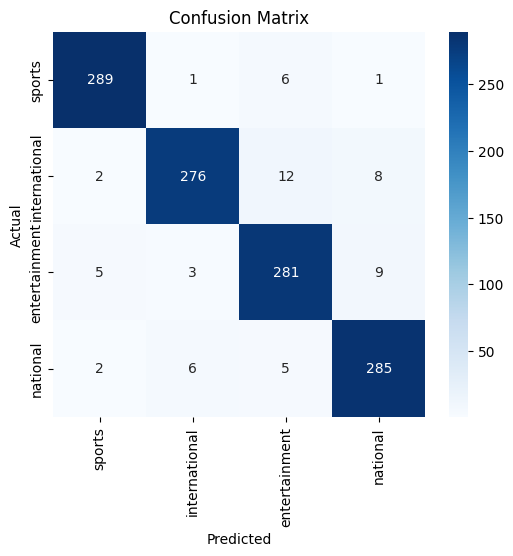

In [ ]:
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        preds = torch.argmax(outputs.logits, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[id2label[i] for i in range(4)]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=id2label.values(), yticklabels=id2label.values(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# BanglaBert-small

In [10]:
# loading the tokenizer and the model sagorsarker/bangla-bert-base from Hugging Face with a classification head for 4 categories.
model_name = "csebuetnlp/banglabert_small"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=4)

# creating a custom PyTorch Dataset class to handle text tokenization and label formatting. Each sample includes input IDs, attention masks, and labels.
class NewsDataset(Dataset):
    def __init__(self, texts, labels):
        self.encodings = tokenizer(list(texts), truncation=True, padding=True, max_length=512)
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.encodings['input_ids'][idx]),
            'attention_mask': torch.tensor(self.encodings['attention_mask'][idx]),
            'labels': torch.tensor(self.labels[idx])
        }

    def __len__(self):
        return len(self.labels)

# We split the dataset bn into 80% training, 10% validation, and 10% testing. Stratified sampling ensures balanced category distribution in each split.We split the dataset bn into 80% training, 10% validation, and 10% testing. Stratified sampling ensures balanced category distribution in each split.
train_texts, temp_texts, train_labels, temp_labels = train_test_split(
    bn['text'], bn['label'], test_size=0.2, random_state=42, stratify=bn['label']
)
val_texts, test_texts, val_labels, test_labels = train_test_split(
    temp_texts, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# We wrap the data using our NewsDataset class and prepare DataLoaders for batch processing. Batch size is set to 8.

batch_size = 8
train_dataset = NewsDataset(train_texts, train_labels.values)
val_dataset = NewsDataset(val_texts, val_labels.values)
test_dataset = NewsDataset(test_texts, test_labels.values)

train_loader = DataLoader(train_dataset, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size= batch_size)
test_loader = DataLoader(test_dataset, batch_size= batch_size)

# Optimizer and scheduler
optimizer = AdamW(model.parameters(), lr=5e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopping config with threshold
best_val_loss = float("inf") # Stores the lowest validation loss seen so far.
patience = 3 # Number of validation rounds to wait for improvement before stopping.
patience_counter = 0
num_epochs = 10
threshold = 0.01 #Minimum improvement in validation loss considered significant.

num_training_steps = len(train_loader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)


# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    for batch in loop:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        train_loss += loss.item()

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        loop.set_postfix(loss=loss.item())

    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            val_loss += outputs.loss.item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Validation Loss: {avg_val_loss:.4f}")

    # Early stopping with threshold
    improvement = best_val_loss - avg_val_loss
    if improvement > threshold:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), "smbert_category_model.pt")
    else:
        patience_counter += 1
        print(f"No significant improvement (Δ={improvement:.4f}), patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# Save tokenizer separately
tokenizer.save_pretrained("smbert_tokenizer")



tokenizer_config.json:   0%|          | 0.00/119 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/585 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/528k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert_small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/55.0M [00:00<?, ?B/s]

Epoch 1: 100%|██████████| 1191/1191 [02:22<00:00,  8.35it/s, loss=0.0152]


Validation Loss: 0.1578


Epoch 2: 100%|██████████| 1191/1191 [02:15<00:00,  8.80it/s, loss=0.00665]


Validation Loss: 0.1134


Epoch 3: 100%|██████████| 1191/1191 [02:13<00:00,  8.95it/s, loss=0.00259]


Validation Loss: 0.1210
No significant improvement (Δ=-0.0076), patience: 1/3


Epoch 4: 100%|██████████| 1191/1191 [02:12<00:00,  8.99it/s, loss=0.00126]


Validation Loss: 0.1168
No significant improvement (Δ=-0.0034), patience: 2/3


Epoch 5: 100%|██████████| 1191/1191 [02:12<00:00,  9.00it/s, loss=0.0167]


Validation Loss: 0.1582
No significant improvement (Δ=-0.0447), patience: 3/3
Early stopping triggered.


('smbert_tokenizer/tokenizer_config.json',
 'smbert_tokenizer/special_tokens_map.json',
 'smbert_tokenizer/vocab.txt',
 'smbert_tokenizer/added_tokens.json',
 'smbert_tokenizer/tokenizer.json')

In [11]:
# Config
model_name = "csebuetnlp/banglabert_small"
num_labels = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Label mapping
label2id = {'sports': 0, 'international': 1, 'entertainment': 2, 'national': 3}
id2label = {v: k for k, v in label2id.items()}

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("smbert_tokenizer")
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
model.load_state_dict(torch.load("smbert_category_model.pt", map_location=device))
model.to(device)
model.eval()


Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at csebuetnlp/banglabert_small and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

✅ Accuracy: 0.9723

Classification Report:
               precision    recall  f1-score   support

       sports       0.99      0.99      0.99       297
international       0.99      0.94      0.96       298
entertainment       0.96      0.98      0.97       298
     national       0.95      0.98      0.97       298

     accuracy                           0.97      1191
    macro avg       0.97      0.97      0.97      1191
 weighted avg       0.97      0.97      0.97      1191



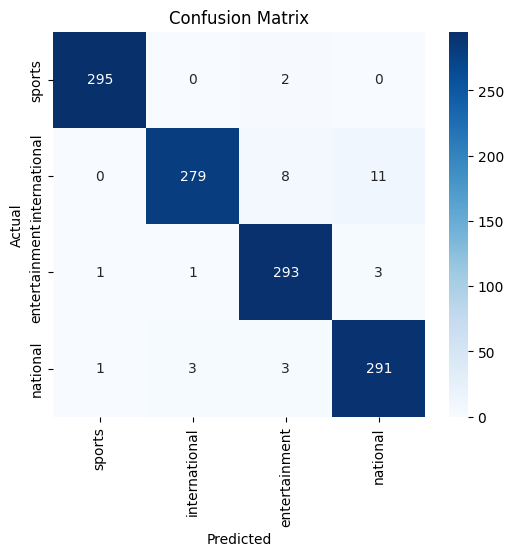

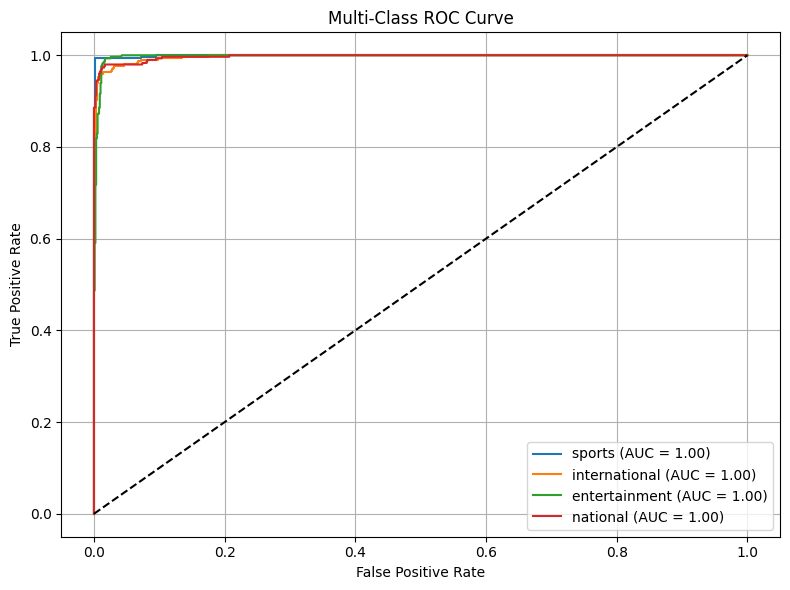

In [12]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch

# Evaluation mode
model.eval()

all_preds = []
all_probs = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        labels = batch['labels'].to(device)
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)

        probs = torch.softmax(outputs.logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_probs.append(probs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Stack all probabilities
all_probs = np.vstack(all_probs)
all_labels = np.array(all_labels)
all_preds = np.array(all_preds)

# Accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f"✅ Accuracy: {accuracy:.4f}")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[id2label[i] for i in range(4)]))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=id2label.values(), yticklabels=id2label.values(), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_test_bin = label_binarize(all_labels, classes=[0, 1, 2, 3])

plt.figure(figsize=(8, 6))
for i in range(4):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], all_probs[:, i])
    auc_score = roc_auc_score(y_test_bin[:, i], all_probs[:, i])
    plt.plot(fpr, tpr, label=f"{id2label[i]} (AUC = {auc_score:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-Class ROC Curve")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()




## 📊 Evaluation Results for BanglaBERT-Small News Classifier

The **`csebuetnlp/banglabert_small`** model was fine-tuned on a Bangla news classification task with four categories: `sports`, `international`, `entertainment`, and `national`. After training and applying early stopping, the model's performance was evaluated on a held-out test set.

### ✅ Accuracy

**Overall Accuracy:** `0.9723`

### 🧾 Classification Report

| Category         | Precision | Recall | F1-Score | Support |
| ---------------- | --------- | ------ | -------- | ------- |
| Sports           | 0.99      | 0.99   | 0.99     | 297     |
| International    | 0.99      | 0.94   | 0.96     | 298     |
| Entertainment    | 0.96      | 0.98   | 0.97     | 298     |
| National         | 0.95      | 0.98   | 0.97     | 298     |
| **Macro Avg**    | 0.97      | 0.97   | 0.97     | 1191    |
| **Weighted Avg** | 0.97      | 0.97   | 0.97     | 1191    |

### 🧩 Confusion Matrix

* Shows strong diagonal dominance with minimal misclassification.
* Most confusion appears between `international` and `entertainment`.

### 📈 ROC Curve (Multi-Class)

* All four categories achieve an **AUC of \~1.00**, indicating excellent separability between classes.
* The ROC curve confirms the model’s robustness across all classes.

